In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 
import pandas as pd
from torch import nn
import collections

import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA


from data_loader import DataLoader
#import viewer functions
from dataViewer import plotTraj, animatePreview, animateLoc, animateTraj

import hdf5_utils as hd
from simulation import Agent, Engine
import h5py
import os


%matplotlib notebook
%load_ext autoreload
%autoreload 2


np.random.seed(42)

In [3]:
def batch(arr1, arr2, n):
    """Yield successive n-sized chunks from l."""
    size = len(arr1)
    for i in range(0, size, n):
        yield arr1[i:min(i + n, size)], arr2[i:min(i + n, size)]
        
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
        

In [98]:


#hidden_layer = [32, 32, 64, 128, 128, 40]

#hidden_layer = [ 128, 128, 40, 32, 32, 64,]
#hidden_layer = [ 50, 30, 10, 20, 30, 30,]
#hidden_layer = [28 ,20, 10, 10]




load_traindata = True

dset = {'neighbors':6,
        'ret_vel':True,
        'nn_vel': True,
        'truth_with_vel': True,
        'shuffle':True,
        'mode': "wrap",
        'step_nr':1,
        'downsample':8,
        'fps':16,
        'name':  "ug-100-007"#"ug-100-045", #"ao-360-400_combine"
       }




param = {'input_s': 2+2*dset['ret_vel']  + dset['neighbors']*(2+2*dset['nn_vel']), #(number_nei+1)*4,
         'hidden_s': [32, 32, 64, 128, 128, 40],
         'output_s': 2+dset['truth_with_vel']*2,
         'epochs':30,
         'batch_size':10,
         'lr':1e-3,
         'decay':0.1,
         'decay_step':5,
         #'dtype':torch.float,
         'device':torch.device("cuda:0"),
         'dataset':dset,
        }

#FPS = 16

BG = "Datasets/UG/ug.png"

#PATH_1 = "Datasets/UG/UG-roh_nachkorrigiert/ug-100-007.txt"



PATH = "Datasets/AO/"
PATH = "Datasets/UG/UG-roh_nachkorrigiert/"
PATH2 = "data/HD5/"


In [109]:

ds = DataLoader(PATH + dset['name'] + ".txt")

ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )


sufix = "_nn{}_s{}_vr{}_m{}_vi{}_st{}_d{}".format(dset['neighbors'],
                                 dset['shuffle'],
                                 dset['truth_with_vel'],
                                 dset['mode'],
                                 dset['ret_vel']+dset['nn_vel'], 
                                 dset['step_nr'],
                                 dset['downsample'])


f_name = PATH2+param['dataset']['name']+sufix+'.h5'

if os.path.isfile(f_name) and load_traindata:

    train, val, test, param['dataset'] = hd.load_trainingdata(f_name)
    print("Trainingdata has been loaded")

else:
    f_x = ds.flip_x

    augmentation = [f_x]
    train, val, test = ds.get_train_data(dset['neighbors'], 
                                         step_nr=dset['step_nr'],
                                         downsample=dset['downsample'],
                                         augmentation=augmentation,
                                         ret_vel=dset['ret_vel'],
                                         nn_vel=dset['nn_vel'],
                                         shuffle=dset['shuffle'],
                                         truth_with_vel=dset['truth_with_vel'],
                                         mode=dset['mode'])
    dset['date'] = time.ctime()
    dset['creator'] = 'zehndiii'
    dset['augmentation'] = str(augmentation)
    param['dataset'] = dset
    
    hd.save_trainingdata(f_name, param, train, val, test)
    print("Training data saved to : {}".format(PATH2+f_name+sufix+'.h5'))

loaded 22 persons
Persons:  22
Frame maximum : 896
Trainingdata has been loaded


/home/zehndi/CNN/Projects/ai-team/hdf5_utils.py:131: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  train = (database.get('train/input').value, database.get('train/truth').value )
/home/zehndi/CNN/Projects/ai-team/hdf5_utils.py:132: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  val = (database.get('val/input').value, database.get('val/truth').value )
/home/zehndi/CNN/Projects/ai-team/hdf5_utils.py:133: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  test = (database.get('test/input').value, database.get('test/truth').value )


In [100]:
hd.print_stats(PATH2+param['dataset']['name']+sufix+'.h5')

File: data/HD5/ug-100-007_nn6_sTrue_vrTrue_mwrap_vi2_st1_d8.h5/
|     Size: 638.32KB
|     @augmentation: [<bound method DataLoader.flip_x of <data_loader.DataLoader object at 0x7fe702cd5dc0>>]
|     @creator: zehndiii
|     @date: Tue Nov 24 14:36:13 2020
|     @downsample: 8
|     @fps: 16
|     @mode: wrap
|     @name: ug-100-007
|     @neighbors: 6
|     @nn_vel: True
|     @ret_vel: True
|     @shuffle: True
|     @step_nr: 1
|     @truth_with_vel: True
|
|Group: test 
|     |-----Dataset: input           - Shape: (1174, 28) float32
|     |-----Dataset: truth           - Shape: (1174, 4) float32
|
|Group: train 
|     |-----Dataset: input           - Shape: (3522, 28) float32
|     |-----Dataset: truth           - Shape: (3522, 4) float32
|
|Group: val 
|     |-----Dataset: input           - Shape: (1174, 28) float32
|     |-----Dataset: truth           - Shape: (1174, 4) float32


# Format training data as tensors

In [101]:
t_input, t_truth = train
v_input, v_truth = val
test_input, test_truth = test

t_i = torch.from_numpy(t_input).to(param['device'])
t_t = torch.from_numpy(t_truth).to(param['device'])

v_i = torch.from_numpy(v_input).to(param['device'])
v_t = torch.from_numpy(v_truth).to(param['device'])

test_i = torch.from_numpy(test_input).to(param['device'])
test_t = torch.from_numpy(test_truth).to(param['device'])




# Define Model

In [24]:


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc_in = nn.Linear(input_size, hidden_size[0]) 
        
        #self.fc_hidden = []
        #for i in range(len(hidden_size)-1):
        self.fc_hidden_1 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc_hidden_2 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc_hidden_3 = nn.Linear(hidden_size[2], hidden_size[3])
        
        self.fc_hidden_4 = nn.Linear(hidden_size[3], hidden_size[4])
        self.fc_hidden_5 = nn.Linear(hidden_size[4], hidden_size[5])

        
        self.fc_out = nn.Linear(hidden_size[-1], output_size)
        self.relu = nn.ReLU()
        #self.drop = nn.Dropout(0.1)
    
    def forward(self, x):
     
        out = self.relu(self.fc_in(x))
        
        #for i in range(len(self.fc_hidden)):
        #    out = self.relu(self.fc_hidden[i](out))
        
        out = self.relu(self.fc_hidden_1(out))
        out = self.relu(self.fc_hidden_2(out))
        out = self.relu(self.fc_hidden_3(out))
        out = self.relu(self.fc_hidden_4(out))
        #out = self.drop(out)
        out = self.relu(self.fc_hidden_5(out))
        
        
        out = self.fc_out(out)
        return out


model = NeuralNet(param['input_s'], param['hidden_s'], param['output_s']).to(param['device'])


In [202]:
#choose loss function - can be played around with
loss_fn = torch.nn.MSELoss(reduction='mean')


optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=param['decay_step'], gamma=param['decay'])


In [203]:

d_len = t_i.shape[0]


pbar = progressbar.ProgressBar(max_value=param['epochs'])
widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = progressbar.ProgressBar(widgets=widgets, maxval=param['epochs']*d_len)
pbar.start()

training_loss = []
validation_loss = [0.0]

for t in range(param['epochs']):
    
    # Train on Batches
    
    p = np.random.permutation(len(t_i))
    t_i = t_i[p]
    t_t = t_t[p]
    
    for  y, (t_i_b, t_t_b) in  enumerate(batch(t_i, t_t, param['batch_size'])):
        y_pred = model(t_i_b)
       
        loss = loss_fn(y_pred, t_t_b)

        model.zero_grad()
       
        loss.backward()

        optimizer.step()
        
        widgets[0] = FormatLabel('loss(t/v) : {:.4} / {:.4} | lr={:.4}'.format(loss.item(),
                                                                            validation_loss[-1],
                                                                            optimizer.param_groups[0]['lr']))
        pbar.update(t*d_len+y*param['batch_size'])
        
        if y%10==9:
            training_loss += [loss.cpu().detach().numpy()]
    
    # Test on validation
    
    loss = []
    with torch.no_grad():
        for v_i_b, v_t_b in batch(v_i, v_t, param['batch_size']):
            y_pred = model(v_i_b)
            loss += [loss_fn(y_pred, v_t_b).cpu().detach().numpy()]
            pbar.update()
    validation_loss.append( np.array(loss).mean() )
    
    scheduler.step()
        

pbar.finish()




loss(t/v) : 15.06 / 50.97 | lr=1e-08 100% |####################| Time:  1:00:28


<IPython.core.display.Javascript object>


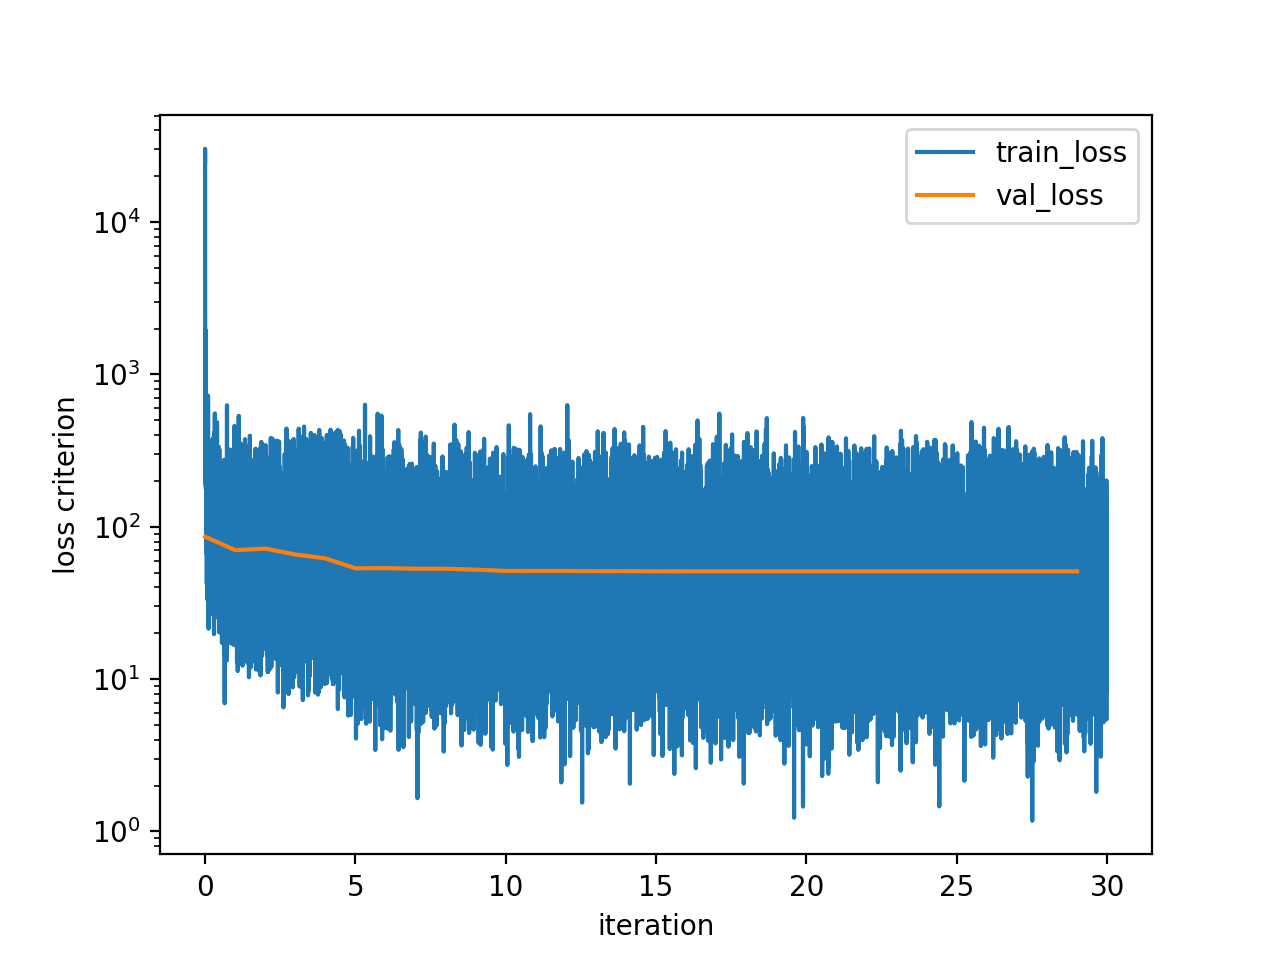

30
72480


In [204]:

train_loss = np.array(training_loss)
val_loss = np.array(validation_loss[1:])

plt.figure()
plt.semilogy(np.arange(len(train_loss))*10*param['batch_size']/d_len, train_loss, label="train_loss")
plt.semilogy(np.arange(len(val_loss)), val_loss, label="val_loss" )
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.legend()
plt.show()
print(len(val_loss))
print(len(train_loss))

In [205]:
model.eval()



NeuralNet(
  (fc_in): Linear(in_features=28, out_features=32, bias=True)
  (fc_hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_2): Linear(in_features=32, out_features=64, bias=True)
  (fc_hidden_3): Linear(in_features=64, out_features=128, bias=True)
  (fc_hidden_4): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_5): Linear(in_features=128, out_features=40, bias=True)
  (fc_out): Linear(in_features=40, out_features=4, bias=True)
  (relu): ReLU()
)

# Check on test set

100% (80550 of 80550) |##################| Elapsed Time: 0:00:53 Time:  0:00:53


<IPython.core.display.Javascript object>


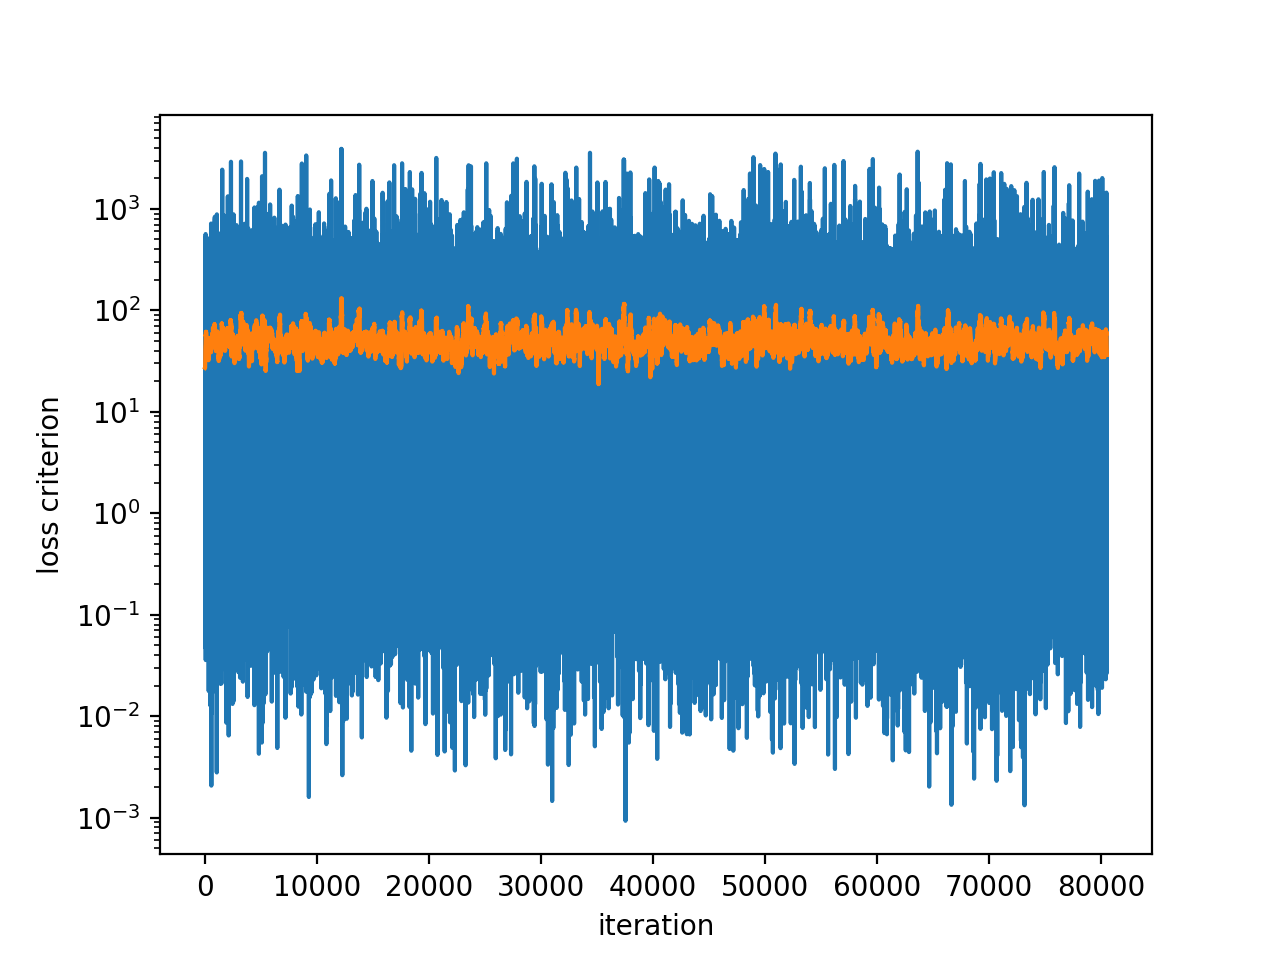

In [206]:

test_dat = []

pbar = progressbar.ProgressBar(maxval=len(test_i))
pbar.start()

i = 0

with torch.no_grad():
    for (ti, tt) in zip(test_i, test_t):
        pred = model(ti)
        loss = loss_fn(pred, tt)
        test_dat.append(loss.cpu().detach().numpy())
     
        if i%10:
            pbar.update(i)
        
        i += 1
        
    pbar.finish()
    
test_dat = np.array(test_dat)

plt.figure()
plt.semilogy(np.arange(len(test_dat)), test_dat)
plt.semilogy(np.arange(len(test_dat)), smooth(test_dat, 100))
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.show()

# Save/ Load model

In [28]:
PATH_M = "data/model/"
name = "model_UG_downsample_good_"
#name = "model_UG_downsample_good_"
name = "model_s_"

suffix_m = "_nn{}_vel{}{}_{}_s{}_{}_{}_e{}_lr{}".format(param['dataset']['neighbors'],
                                                         param['dataset']['ret_vel'],param['dataset']['nn_vel'],param['dataset']['truth_with_vel'],
                                                         param['input_s'],param['hidden_s'],param['output_s'],
                                                         param['epochs'],
                                                         param['lr'],
                                                        )


#f_name = PATH_M+name+"sweep_vel.h5"
f_name = PATH_M+name+suffix_m+".h5"    

#hd.print_stats(f_name)
suffix_m

'_nn6_velTrueTrue_True_s28_[32, 32, 64, 128, 128, 40]_4_e30_lr0.001'

In [193]:

param['msg'] = "Scan with a downsampling to 2fps and no velocity in truth on bottleneck "


hd.save_torch(model, optimizer, f_name, param, prefix="model_1", scan=True)

In [29]:
model , param = hd.load_torch(f_name, NeuralNet, prefix="model_1")
model.eval()

multi_model
{'hidden_s': array([ 32,  32,  64, 128, 128,  40]), 'input_s': 28, 'layers': array(['fc_in.weight', 'fc_in.bias', 'fc_hidden_1.weight',
       'fc_hidden_1.bias', 'fc_hidden_2.weight', 'fc_hidden_2.bias',
       'fc_hidden_3.weight', 'fc_hidden_3.bias', 'fc_hidden_4.weight',
       'fc_hidden_4.bias', 'fc_hidden_5.weight', 'fc_hidden_5.bias',
       'fc_out.weight', 'fc_out.bias'], dtype=object), 'output_s': 4}


/home/zehndi/CNN/Projects/ai-team/hdf5_utils.py:180: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  stat[l] = torch.from_numpy(mod.get(l).value,).to(layer_param['device'])


NeuralNet(
  (fc_in): Linear(in_features=28, out_features=32, bias=True)
  (fc_hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_2): Linear(in_features=32, out_features=64, bias=True)
  (fc_hidden_3): Linear(in_features=64, out_features=128, bias=True)
  (fc_hidden_4): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_5): Linear(in_features=128, out_features=40, bias=True)
  (fc_out): Linear(in_features=40, out_features=4, bias=True)
  (relu): ReLU()
)

In [30]:
hd.print_stats(f_name)

File: data/model/model_s__nn6_velTrueTrue_True_s28_[32, 32, 64, 128, 128, 40]_4_e30_lr0.001.h5/
|     Size: 185.09KB
|     @mode: multi_model
|     @models: [b'dummy' b'model_1']
|
|Group: model_1 
|     @batch_size: 10
|     @creator: zehndiii
|     @date: Mon Nov 23 21:47:37 2020
|     @decay: 0.1
|     @decay_step: 5
|     @device: cuda:0
|     @epochs: 30
|     @lr: 0.001
|     @mode: single_model
|     @msg: Scan with a downsampling to 
|     |
|     |Group: dataset 
|     |     @augmentation: []
|     |     @creator: zehndiii
|     |     @date: Mon Nov 23 21:35:12 2020
|     |     @downsample: 8
|     |     @fps: 16
|     |     @mode: wrap
|     |     @name: ug-100-045
|     |     @neighbors: 6
|     |     @nn_vel: True
|     |     @ret_vel: True
|     |     @shuffle: True
|     |     @step_nr: 1
|     |     @truth_with_vel: True
|     |
|     |Group: model 
|     |     @hidden_s: [ 32  32  64 128 128  40]
|     |     @input_s: 28
|     |     @layers: ['fc_in.weight' 'fc_in.bias'

In [137]:
[] + ["hallo"]

['hallo']

# Singel agent

In [111]:



test_person = 10

da = DataLoader(None)


da.copy(ds)
# crop the standing phase
da.data = da.data[ da.data['f']>100]

frames_o, pos_vel_o = da.person(test_person, )
#frames, pos_vel = da.grab_roi(frames_o, pos_vel_o, x_pad=50)

da.remove_person(test_person)

print(frames_o[0], frames_o[-1])

agent = Agent(model,
              FPS=param['dataset']['fps']/param['dataset']['downsample'],
              pos_vel_0=pos_vel_o[0],
              frame_0=frames_o[0],
              truth_with_vel=param['dataset']['truth_with_vel'],
              device=param['device'],
              id=1000+test_person )



print(agent.id )
print(pos_vel_o[0])


sim = Engine(da, agents=[agent],
             stop_agent=True,
             nn=param['dataset']['neighbors'],
             ret_vel=param['dataset']['ret_vel'],
             nn_vel=param['dataset']['nn_vel'],
             truth_with_vel=param['dataset']['truth_with_vel'],
             mode=param['dataset']['mode'],
             downsample=param['dataset']['downsample'],
            )

sim.run(0, 1000)#frames_o[-1], )


dp = DataLoader(None)
dp.copy(sim.ds)
dp.append_person(test_person, frames_o, pos_vel_o[:,:2], vel=pos_vel_o[:,2:] )


327 476
1010
[-518.201 -203.292  -12.992  142.048]
sim from : 0 to 1000


frame: 1000 100% |#############################################| Time:  0:00:01


In [116]:
def get_mean_speed(data, id, use_roi=True, mode="both", normalize=False, pos=(0, 0)):
    
    frames, pos_vel = data.person(id)
    frames, pos_vel = data.grab_roi(frames, pos_vel, x_pad=-50)
    
    if not normalize:
        if mode =='x':
             vel_m = pos_vel[:,2].mean()
        elif mode == 'y':
             vel_m = pos_vel[:,3].mean()
        elif mode == 'both':
             vel_m = np.sqrt((pos_vel[:,2:]**2).sum(axis=1)).mean()
    else:
        if mode =='x':
            vel = pos_vel[:,2]
            
            r = pos_vel[0] - pos[0]
            vel /= r
            
            vel_m = vel.mean()
        elif mode == 'y':
            vel = pos_vel[:,3]
            
            r = pos_vel[1] - pos[1]
            vel /= r
            
            vel_m = vel.mean()
        elif mode == 'both':
            vel = np.sqrt((pos_vel[:,2:]**2).sum(axis=1))
            
            r = np.sqrt(( (pos_vel[:,:2]-pos)**2).sum(axis=1))
            vel /= r
            
            vel_m = vel.mean()
        
    
    
    #print(frames)
    #print(pos_vel)
    print("ID ", id ," vel :",  vel_m)

get_mean_speed(dp, test_person, normalize=True)
get_mean_speed(dp, 1000+test_person, normalize=True)
    

ID  10  vel : 1.3024526010134208
ID  1010  vel : 1.02589322038623


<IPython.core.display.Javascript object>


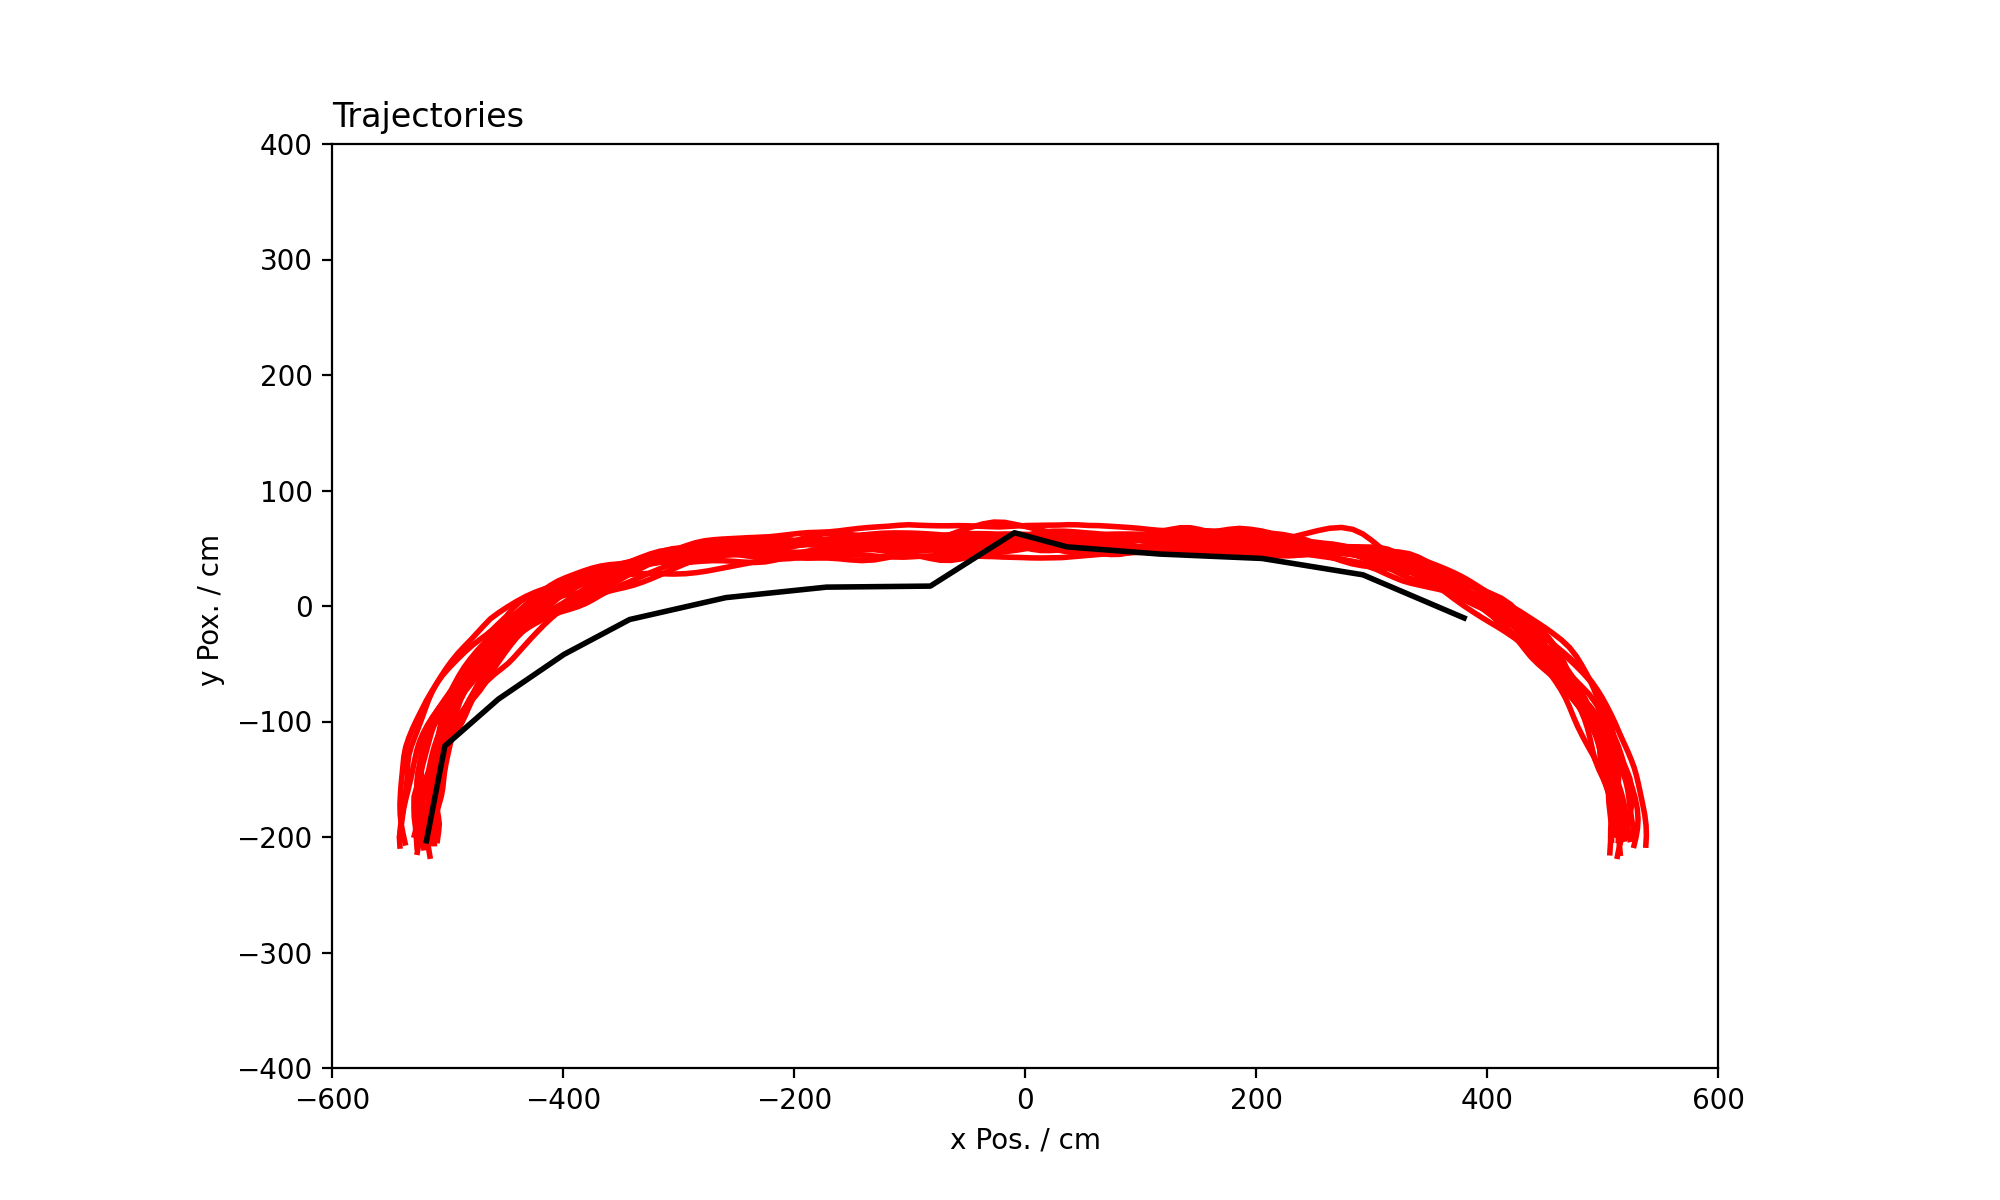

In [104]:



plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,
         ai=[ 1000+test_person],#test_person,
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

<IPython.core.display.Javascript object>


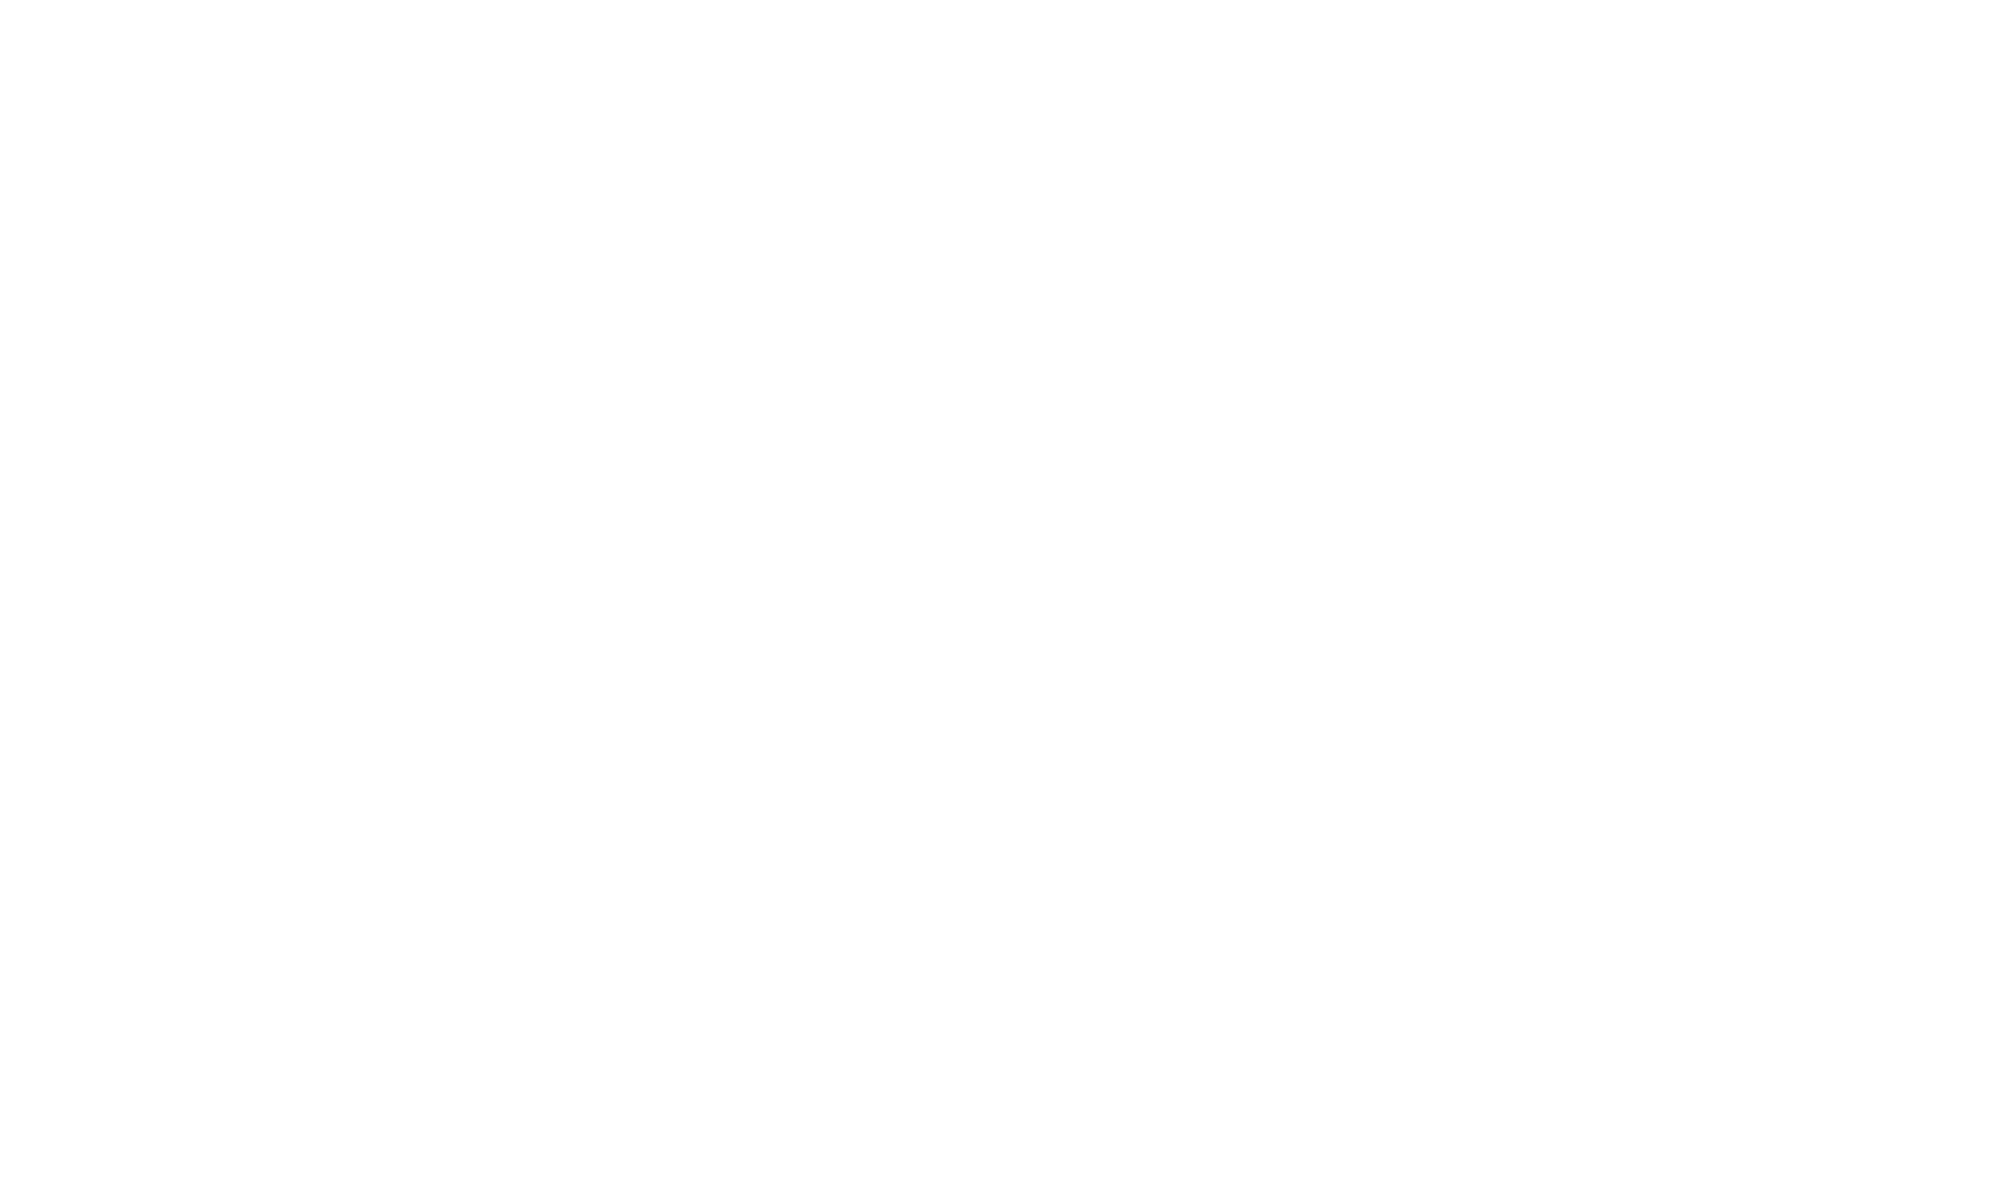

In [105]:
ani = animateLoc(dp, frame_start=frames_o[0], frame_stop=frames_o[-1],ai=[1000+test_person],
             boundaries=[-800, 600, -200, 400], step=8, fps=16, title="ululululu", save=True,
             path="downsapling_8.gif"
             )
display(ani)

In [ ]:
animatePreview(dp, boundaries=[-600, 600, -250, 150], step=5)

In [ ]:
ani = animateTraj(dp, frame_start=frames_o[0], frame_stop=frames_o[-1], boundaries=[-600, 600, -250, 150], step=1, fps=16, title="Trajectory Animation")
ani

In [53]:
type(param['input_s'])

tuple

# Multi agent simulation

ID  10  vel : 148.2705842628046
ID  13  vel : 138.55862095925346
ID  16  vel : 143.50960412145355
ID  20  vel : 139.21516089694683
ID  22  vel : nan
ID  26  vel : nan
ID  30  vel : nan
ID  35  vel : nan
ID  40  vel : nan
People in Dataset:  17
Agents in Dataset:  5
Frame max:  896
sim from : 0 to 896


<ipython-input-103-2cc7c03aa933>:11: RuntimeWarning: Mean of empty slice.
  vel_m = np.sqrt((pos_vel[:,2:]**2).sum(axis=1)).mean()
/home/zehndi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
frame:  896 100% |#############################################| Time:  0:00:01


<IPython.core.display.Javascript object>


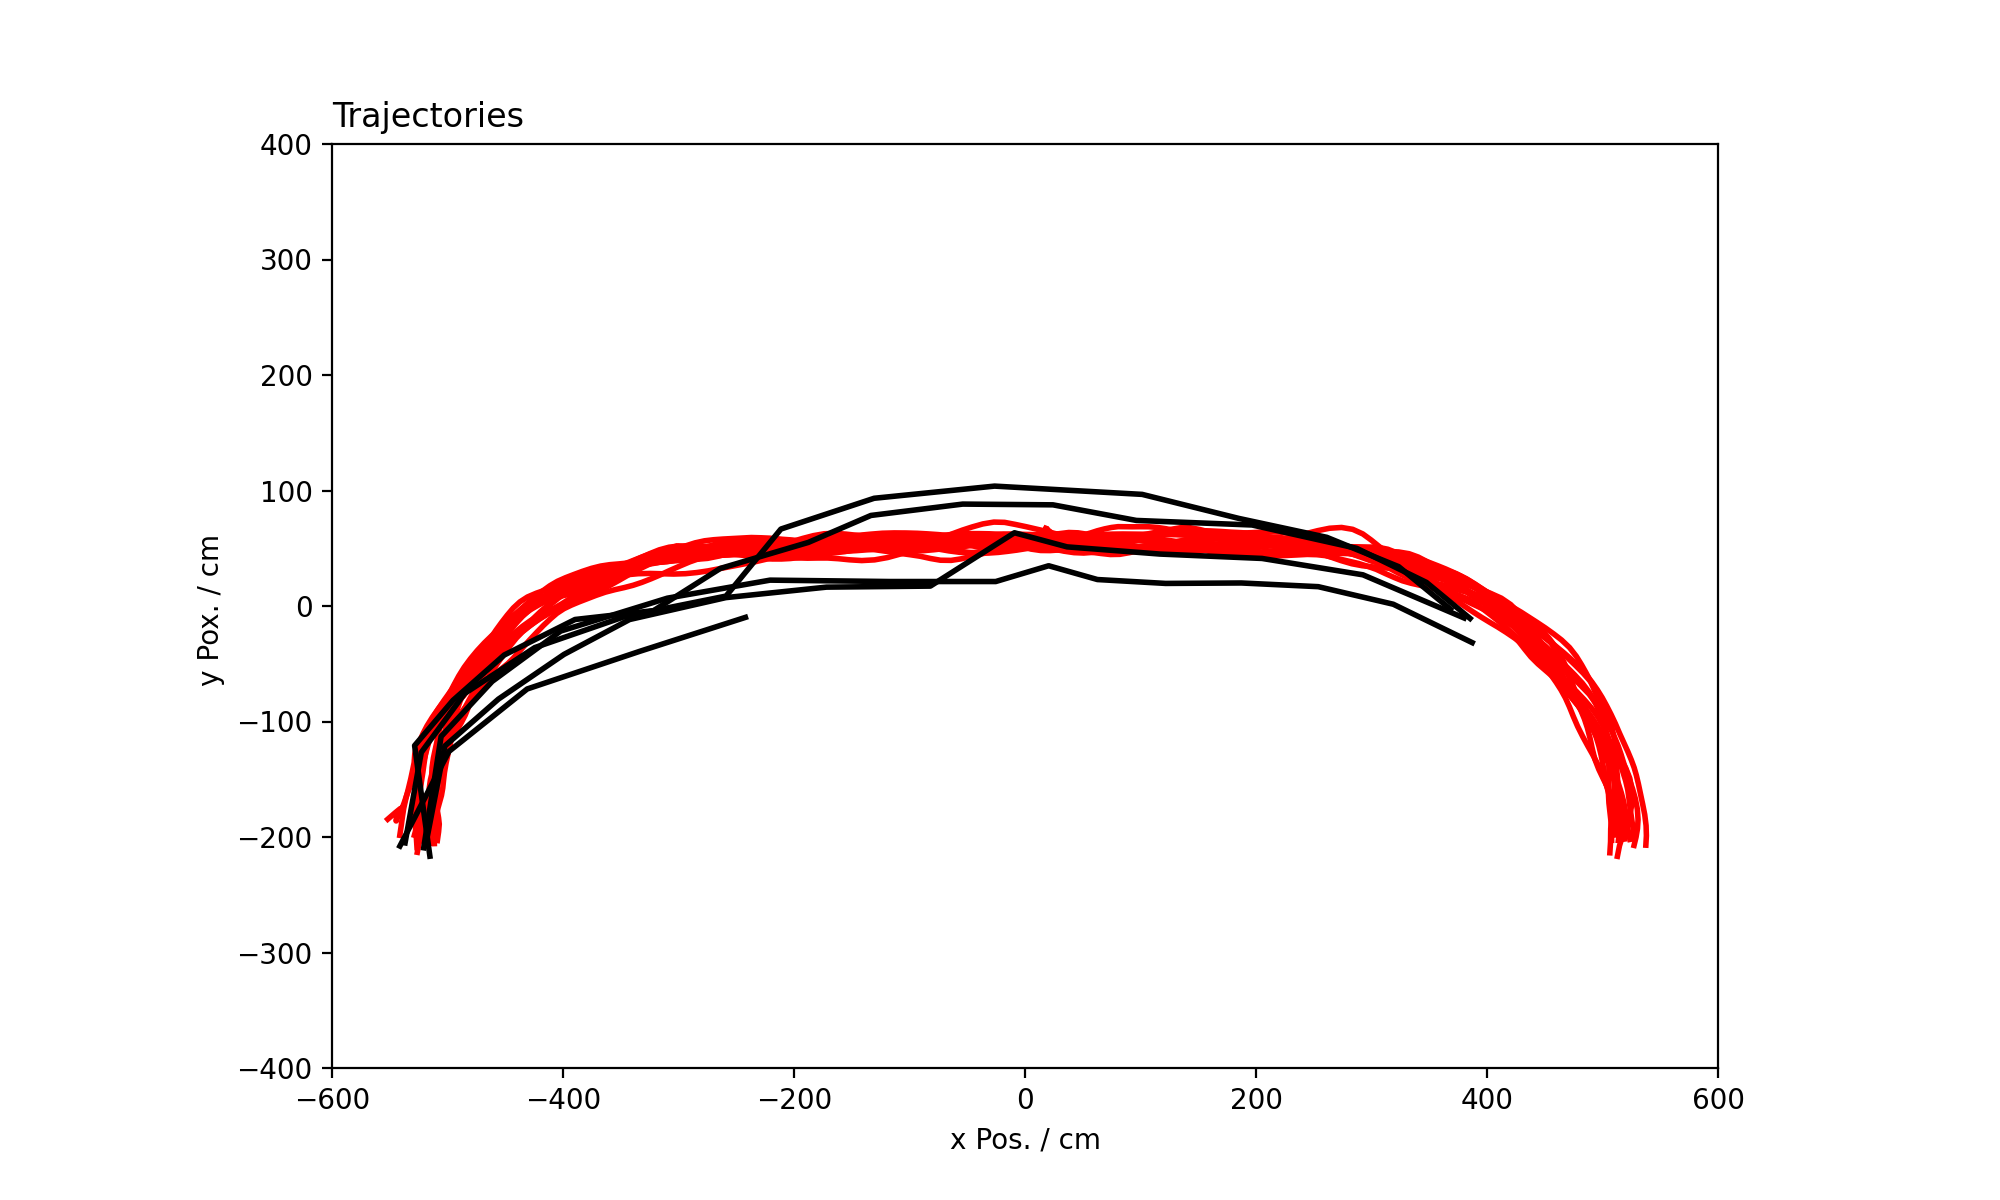

In [106]:
agents_id = np.array([10, 13, 16,  20, 22, 26,  30, 35, 40, ]) #120, 160, 200])

#agents_id, _ = ds.frame(5)



da = DataLoader(None)

da.copy(ds)
#da.data = da.data[ da.data['f']>200]


#agents_id = da.data['p'].unique()[::5]

agents = []

frame_max = 0

for test_person in agents_id:

    frames_o, pos_vel_o =  da.person( test_person, )
    #frames_o, pos_vel_o =  da.grab_roi( *da.person(test_person, ), x_pad=100 )
    
    get_mean_speed(da, test_person)
    da.remove_person(test_person)

    
    if len(frames_o)<1:
        continue
    
    frame_max = max(frames_o[-1], frame_max)
    
    agents += [Agent(model,
                     FPS=param['dataset']['fps']/param['dataset']['downsample'],
                     pos_vel_0=pos_vel_o[0],
                     frame_0=frames_o[0],
                     truth_with_vel=param['dataset']['truth_with_vel'],
                     device=param['device'],
                     id=1000+test_person )]

#for id in da.data['p'].unique():
#    da.remove_person(id)

print("People in Dataset: ", da.persons)
print("Agents in Dataset: ", len(agents))
print("Frame max: ", frame_max)

sim = Engine(da, agents=agents,
             nn=param['dataset']['neighbors'],
             ret_vel=param['dataset']['ret_vel'],
             nn_vel=param['dataset']['nn_vel'],
             truth_with_vel=param['dataset']['truth_with_vel'],
             mode=param['dataset']['mode'],
             downsample=param['dataset']['downsample'],
             stop_agent=True)

sim.run(0,frame_max, )



dp = DataLoader(None)
dp.copy(sim.ds)


plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,
         ai=agents_id+1000,
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

In [107]:
for j in agents_id:
    get_mean_speed(dp, 1000+j)
    

ID  1010  vel : 97.10711645548866
ID  1013  vel : 116.37381569437647
ID  1016  vel : 112.84061558960896
ID  1020  vel : 93.6322248241947
ID  1022  vel : nan
ID  1026  vel : nan
ID  1030  vel : nan
ID  1035  vel : nan
ID  1040  vel : nan


<ipython-input-103-2cc7c03aa933>:11: RuntimeWarning: Mean of empty slice.
  vel_m = np.sqrt((pos_vel[:,2:]**2).sum(axis=1)).mean()
/home/zehndi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


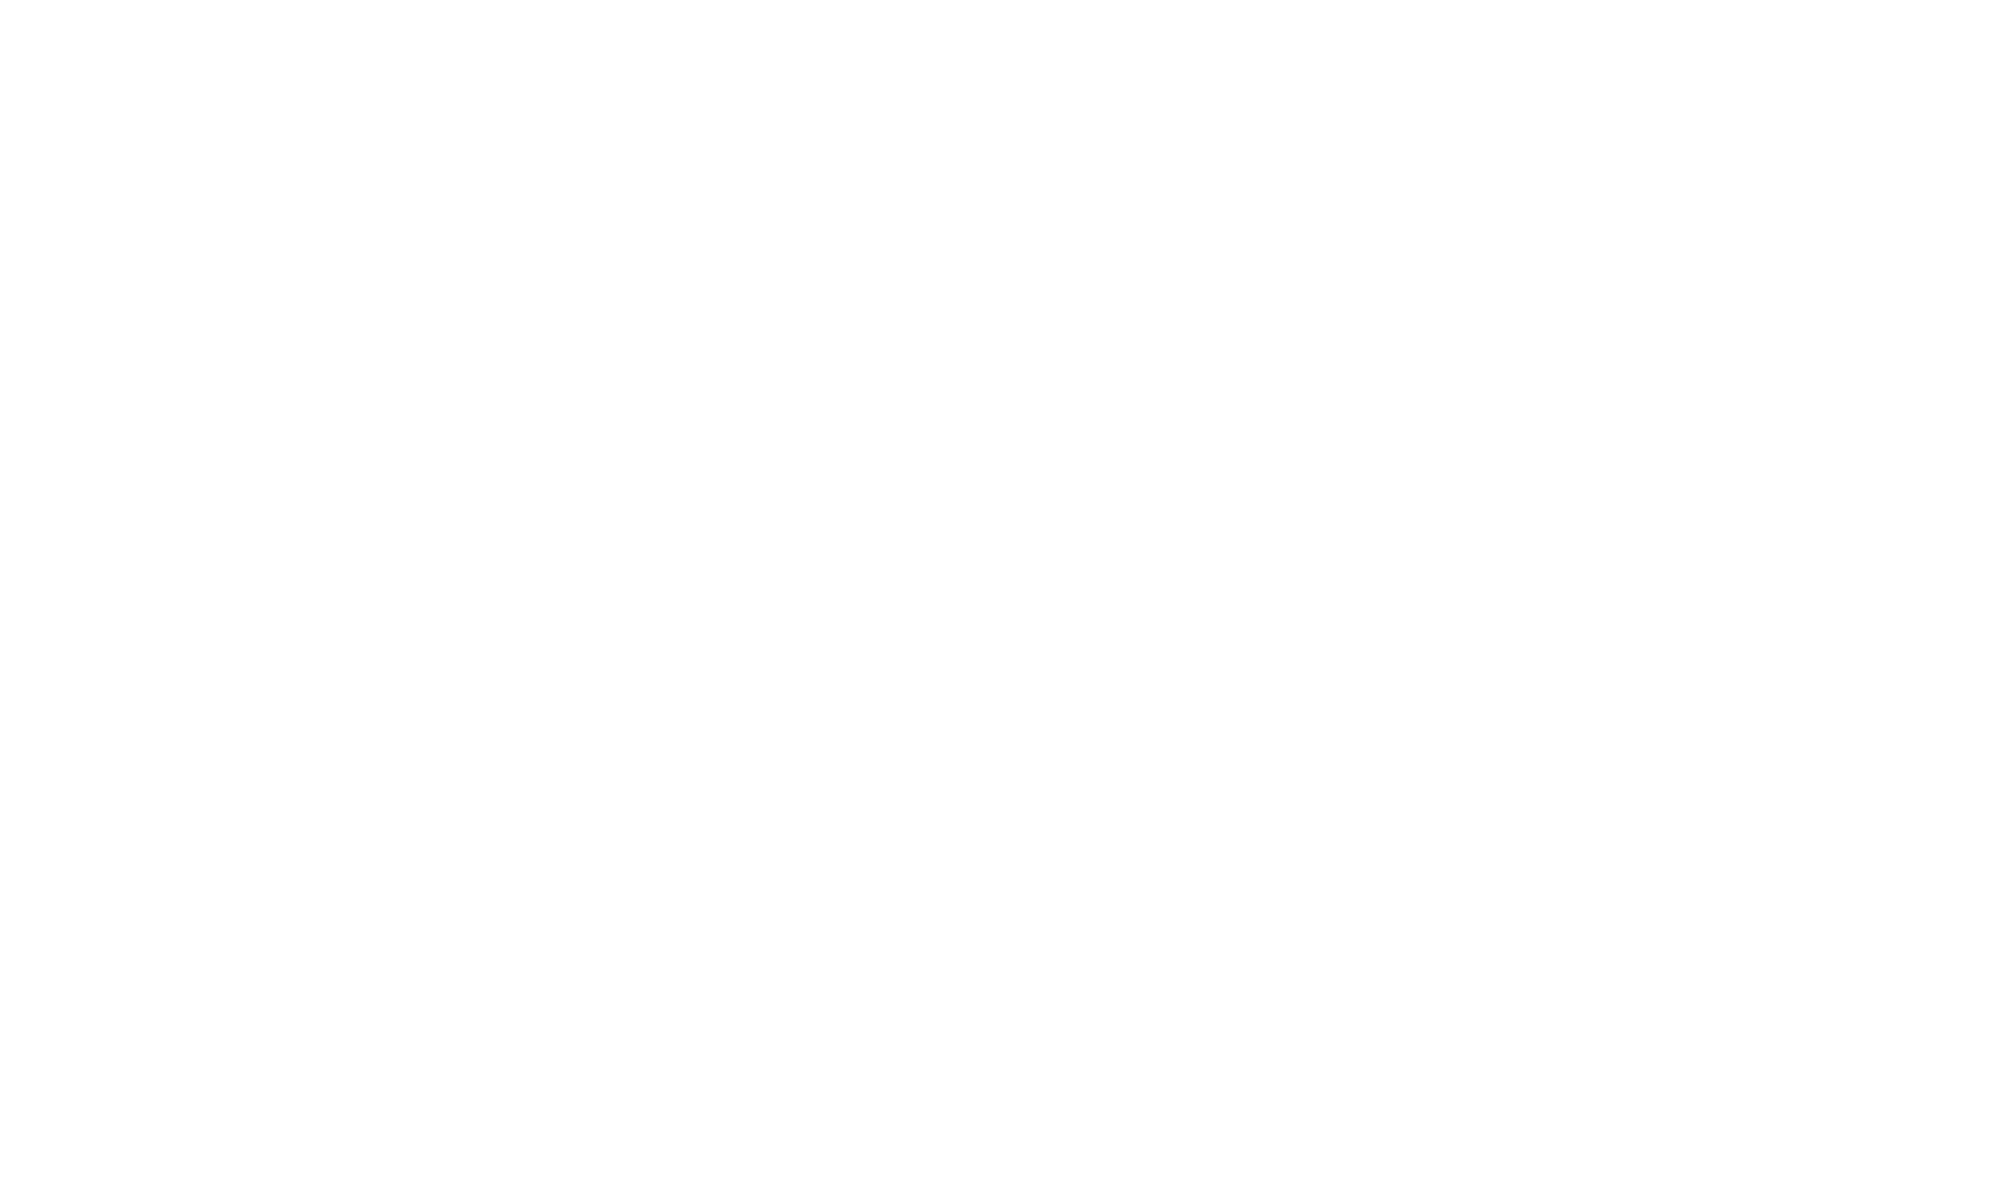

In [108]:
ani = animateLoc(dp, frame_start=0, frame_stop=1000,ai=agents_id+1000,
             boundaries=[-800, 600, -200, 400], step=1, fps=16, title="ululululu", save=True,
             path="downsapling_8_multi.gif")
display(ani)

In [ ]:
def load_torch(f_name, MODEL_class):
    
    db = h5py.File(f_name, 'r')
    
    params = hd.load_attrs(db)
    db_params = hd.load_attrs(db['dataset'])
    
    mod = db['model']
    mod_params = hd.load_attrs(mod)
    
    params['dataset'] = db_params
    params['input_s'] = mod_params['input_s'],
    params['hidden_s'] = mod_params['hidden_s'],
    params['output_s'] = mod_params['output_s'],
    params['device'] = torch.device(params['device'])
    
    
    model = MODEL_class(mod_params['input_s'], mod_params['hidden_s'], mod_params['output_s'])
    
    
    stat = collections.OrderedDict() 
    for l in mod_params['layers']:
        layer_param = hd.load_attrs(mod[l])
        stat[l] = torch.from_numpy(mod.get(l).value,).to(layer_param['device'])
    
    db.close()
    
    model.load_state_dict(stat)
    
    
    
    return model, params


def save_torch(model, optimizer, f_name, param, crator="zehndiii"):
    #TODO Apend mode
    #TODO no overwrite
    
    db = h5py.File(f_name, 'w')
    
    # write general settings
    hd.write_attrs(db, {'creator':"zehndiii",       # write general attributes
                      'date':time.ctime(),
                      'epochs':param['epochs'],
                      'batch_size':param['batch_size'],
                #'optimizer':str(type(optimizer)),
                      'lr':param['lr'],
                      'decay':param['decay'],
                      'decay_step':param['decay_step'],
                      'device':str(param['device'])
                       })
    
    

    # write dataset settings
    dataset = db.create_group('/dataset')
    
    hd.write_attrs(dataset, param['dataset'])
    """
    {'creator':creator,       # write general attributes
                      'date':date,
                      'neighbors':number_nei,
                      'augmentation':str(augmentation),
                      'shuffle':shuffle,
                      'truth_with_vel':truth_with_vel,
                      'mode':mode,
                      'fps':FPS
                     }
    """
    
    # write model and settings
    mod = db.create_group('/model')
   
    stat = model.state_dict()
    
    layers = []
    
    for k, v in stat.items():
        
        layers += [k]
        
        dat = v.cpu().detach().numpy()
        ds = mod.create_dataset( name=k,shape=v.shape, 
                                         dtype=dat.dtype,
                                         data=dat, compression="lzf" )

        hd.write_attrs(ds, {'device':str(v.device.type),
                            'dtype':str(v.dtype),
                         })
    
    hd.write_attrs(mod, {'input_s':param['input_s'],
                         'hidden_s':param['hidden_s'],
                         'output_s':param['output_s'],
                         'layers':layers,
                         })
    
    db.close()

In [7]:
# hdf 5 dump

f_name = PATH2+param['dataset']['name']+sufix+'.h5'

def save_trainingdata(f_name, train, val, test ):


    database = h5py.File(f_name, 'w')

    hd.write_attrs(database, param['dataset'] ) 
    
    train_h = database.create_group('/train')
    train_h.create_dataset( name='input',shape=train[0].shape, 
                                         dtype=train[0].dtype,
                                         data=train[0], compression="lzf" )
    train_h.create_dataset( name='truth',shape=train[1].shape, 
                                         dtype=train[1].dtype,
                                         data=train[1], compression="lzf" )
    val_h = database.create_group('/val')
    val_h.create_dataset( name='input',shape=val[0].shape, 
                                         dtype=val[0].dtype,
                                         data=val[0], compression="lzf" )
    val_h.create_dataset( name='truth',shape=val[1].shape, 
                                         dtype=val[1].dtype,
                                         data=val[1], compression="lzf" )
    test_h = database.create_group('/test')
    test_h.create_dataset( name='input',shape=test[0].shape, 
                                         dtype=test[0].dtype,
                                         data=test[0], compression="lzf" )
    test_h.create_dataset( name='truth',shape=test[1].shape, 
                                         dtype=test[1].dtype,
                                         data=test[1], compression="lzf" )

    database.close()
    print("Training data saved to : {}".format(PATH2+fname+sufix+'.h5'))
    
def load_trainingdata(file_name):
    database = h5py.File(file_name, 'r')                  # open db

    param['dataset'] = hd.load_attrs(database)                        # print attrs if debug

    train = (database.get('train/input').value, database.get('train/truth').value )
    val = (database.get('val/input').value, database.get('val/truth').value )
    test = (database.get('test/input').value, database.get('test/truth').value )

    database.close()
    return train, val, test

In [ ]:
torch.save(model.state_dict(), "data/model/model_paper_dropout.dat")
load_path = "data/model/model_paper_dropout.dat"

model = NeuralNet(D_in, hidden_layer, D_out).to(device)

model.load_state_dict(torch.load(load_path))
model.eval()



In [ ]:
ai = sim.agents[0]
tr = np.vstack( ai.traj )

print("agent")
print(tr[:5])

print(ai.pos)
frames, traj = sim.ds.person(test_person+1000)

print("dataset")
#print(frames[:])
print(traj[:5])

plt.figure()

offset = 0
end = -1
plt.plot(tr[:,0], tr[:,1]) 



plt.plot(traj[offset: end,0], traj[offset:end,1])

print(frames[offset])

#plt.xlim([-600, 600])
#plt.ylim([-150, 150])

plt.show()

"""
[[-342.531 -3.04867 -1.024000000000342 4.645119999999999]
 [-332.4825439453125 -3.1519365310668945 0.6280288696289062
  -0.006454154849052429]
 [-322.0271301269531 -2.130854606628418 0.6534633636474609
  0.06381762027740479]
 [-312.77081298828125 -3.785721778869629 0.5785198211669922
  -0.10342919826507568]
 [-302.70819091796875 -2.7985124588012695 0.6289138793945312
  0.06170058250427246]]

"""

In [ ]:

#define network



model = torch.nn.Sequential(
    
    torch.nn.Linear(D_in, 50), 
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
    
    torch.nn.ReLU(),
    torch.nn.Linear(10, 50),
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(50, 30),
    
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(30, D_out), 
)



hidden_size = 28#50
hidden_size2 = 20
hidden_size3 = 10#50
hidden_size4 = 10


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
         
        out = self.drop( self.fc3(out) )
        
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

model = NeuralNet(D_in, hidden_size, hidden_size2, hidden_size3, hidden_size4,D_out).to(device)


#if device.type.startswith("cuda"):
#    model.cuda()

In [ ]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torch.nn.ModuleDict({
            'lstm': torch.nn.LSTM(
                input_size=D_in,    # 45, see the data definition
                hidden_size=l_o,  # Can vary
            ),
            'linear1': torch.nn.Linear(
                in_features=l_o,
                out_features=D_out)
        })
        
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        x = x.view(x_seq_len, -1, x_features)
       
        # Data is fed to the LSTM
        out, _ = self.model['lstm'](x)
        

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.view(x_batches, x_seqs, x_seq_len, -1)
      

        # Data is fed to the Linear layer
        out = self.model['linear1'](out)
       

        # The prediction utilizing the whole sequence is the last one
        y_pred = out[:, :, -1].unsqueeze(-1)
       

        return y_pred


model = Model()